# **SPAM classification task**


In [1]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Advanced_ML_DL_spam_classification_L4/spam.csv

--2021-11-12 08:05:43--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Advanced_ML_DL_spam_classification_L4/spam.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 198.23.119.245
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|198.23.119.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv’

spam.csv            100%[===================>] 491.86K  --.-KB/s    in 0.09s   

2021-11-12 08:05:44 (5.26 MB/s) - ‘spam.csv’ saved [503663/503663]



In [2]:
!pip install nltk
!pip install wordcloud
!pip install tensorflow==2.4

     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 462 kB 41.2 MB/s 
     |████████████████████████████████| 2.9 MB 35.8 MB/s 
     |████████████████████████████████| 3.8 MB 39.2 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68716 sha256=96d0fd9c231611fb7b3c86816163c5a03a988f52c1605502f5615dcb86ab10c6
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.41.1
    Uninstalling grpcio-1.41.1:
      Successfully uninstalled grpcio-1.41.1
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Suc

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import nltk, re, collections, pickle, os 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 5)
plt.style.use('ggplot')
seed = 42

import warnings
warnings.filterwarnings(action = "ignore")
warnings.simplefilter(action = 'ignore', category = Warning)
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
pd.set_option("precision", 3)
pd.options.display.float_format = '{:.3f}'.format

In [6]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'accuracy' in s and 'val' in s]
    
    plt.figure(figsize = (12, 5), dpi = 100)
    COLOR = 'gray'
    
    plt.rc('legend', fontsize = 14)   
    plt.rc('figure', titlesize = 12)  
        
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
   
    epochs = range(1, len(history.history[loss_list[0]]) + 1)
    
  
    plt.subplot(1, 2, 1)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(str(format(history.history[l][-1],'.4f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    
    
    plt.subplot(1, 2, 2)
    plt.subplots_adjust(wspace = 2, hspace = 2)
    plt.rcParams['text.color'] = 'black'
    plt.rcParams['axes.titlecolor'] = 'black'
    plt.rcParams['axes.labelcolor'] = COLOR
    plt.rcParams['xtick.color'] = COLOR
    plt.rcParams['ytick.color'] = COLOR
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b-o',
                 label = 'Train (' + str(format(history.history[l][-1],'.4f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g',
                 label = 'Valid (' + str(format(history.history[l][-1],'.4f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(facecolor = 'gray', loc = 'best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_conf_matr(conf_matr, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.winter):

  import itertools

  accuracy = np.trace(conf_matr) / np.sum(conf_matr).astype('float')
  sns.set(font_scale = 1.4)

  plt.figure(figsize = (12, 8))
  plt.imshow(conf_matr, interpolation = 'nearest', cmap = cmap)
  title = '\n' + title + '\n'
  plt.title(title)
  plt.colorbar()

  if classes is not None:
      tick_marks = np.arange(len(classes))
      plt.xticks(tick_marks, classes, rotation = 45)
      plt.yticks(tick_marks, classes)

  if normalize:
      conf_matr = conf_matr.astype('float') / conf_matr.sum(axis = 1)[:, np.newaxis]


  thresh = conf_matr.max() / 1.5 if normalize else conf_matr.max() / 2
  for i, j in itertools.product(range(conf_matr.shape[0]), range(conf_matr.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.2f}%".format(conf_matr[i, j] * 100),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(conf_matr[i, j]),
                    horizontalalignment = "center",
                    fontweight = 'bold',
                    color = "white" if conf_matr[i, j] > thresh else "black")
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\n\nAccuracy = {:0.2f}%; Error = {:0.2f}%'.format(accuracy * 100, (1 - accuracy) * 100))
  plt.show()


def plot_words(set, number):
  words_counter = collections.Counter([word for sentence in set for word in sentence.split()]) # finding words along with count
  most_counted = words_counter.most_common(number)
  most_count = pd.DataFrame(most_counted, columns = ["Words", "Amount"]).sort_values(by = "Amount") # sorted data frame
  most_count.plot.barh(x = "Words", 
                       y = "Amount",
                       color = "blue",
                       figsize = (10, 15))
  for i, v in enumerate(most_count["Amount"]):
    plt.text(v, i,
             " " + str(v),
             color = 'black',
             va = 'center',
             fontweight = 'bold')

def word_cloud(tag):
  df_words_nl = ' '.join(list(df_spam[df_spam['feature'] == tag]['message']))
  df_wc_nl = WordCloud(width = 600, height = 512).generate(df_words_nl)
  plt.figure(figsize = (13, 9), facecolor = 'k')
  plt.imshow(df_wc_nl)
  plt.axis('off')
  plt.tight_layout(pad = 1)
  plt.show()

In [7]:
df_spam = pd.read_csv('spam.csv', encoding = 'latin-1')

In [8]:
df_spam = df_spam.filter(['v1', 'v2'], axis = 1)
df_spam.columns = ['feature', 'message']
df_spam.drop_duplicates(inplace = True, ignore_index = True)
print('Number of null values:\n')
df_spam.isnull().sum()

Number of null values:



feature    0
message    0
dtype: int64

In [9]:
df_spam['feature'].value_counts()

ham     4516
spam     653
Name: feature, dtype: int64

In [10]:
df_spam.shape, df_spam.columns

((5169, 2), Index(['feature', 'message'], dtype='object'))

In [11]:
df_spam.describe().T

,count,unique,top,freq
feature,5169,2,ham,4516
message,5169,5169,2 laptop... I noe infra but too slow lar... I ...,1


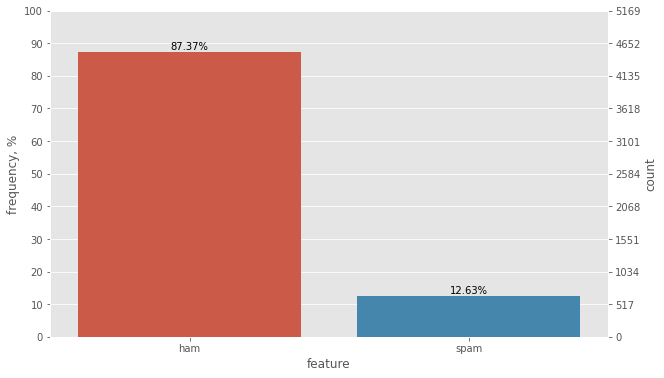

In [12]:
plt.figure(figsize = (10, 6))
counter = df_spam.shape[0]
ax1 = sns.countplot(df_spam['feature'])
ax2 = ax1.twinx()                      
ax2.yaxis.tick_left()                
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position('right')  
ax2.yaxis.set_label_position('left')
ax2.set_ylabel('frequency, %')


for p in ax1.patches:
  x = p.get_bbox().get_points()[:, 0]
  y = p.get_bbox().get_points()[1, 1]
  ax1.annotate('{:.2f}%'.format(100. * y / counter),
              (x.mean(), y),
              ha = 'center',
              va = 'bottom')


ax1.yaxis.set_major_locator(ticker.LinearLocator(11))


ax2.set_ylim(0, 100)
ax1.set_ylim(0, counter)


ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))


ax2.grid(None)

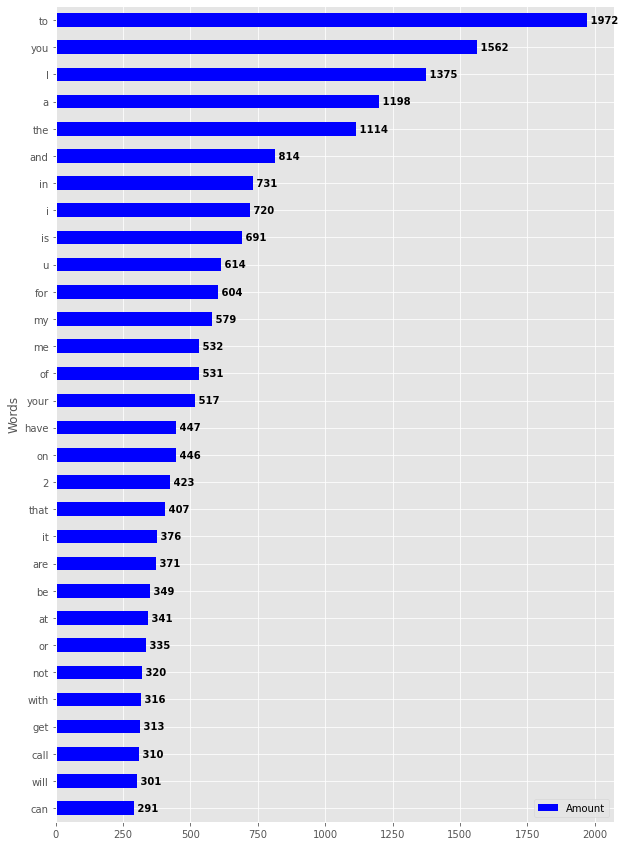

In [13]:
plot_words(df_spam['message'], number = 30)

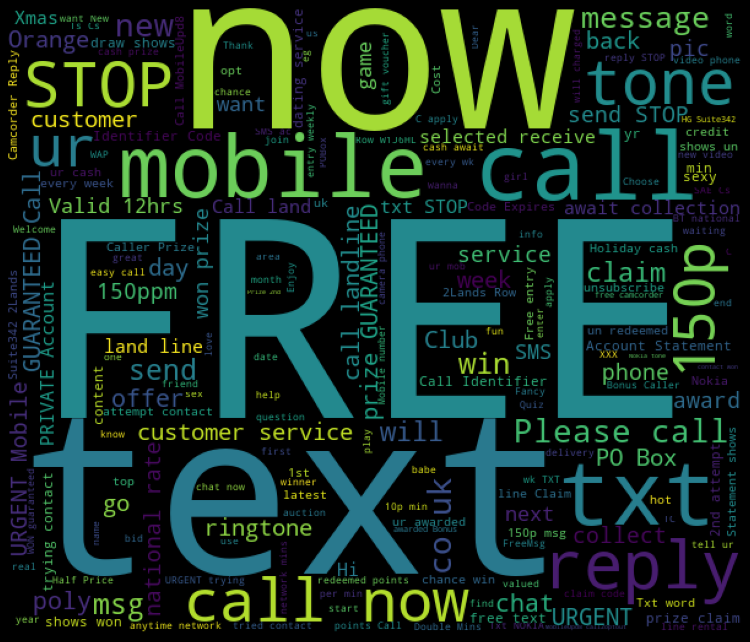

In [14]:
word_cloud('spam')

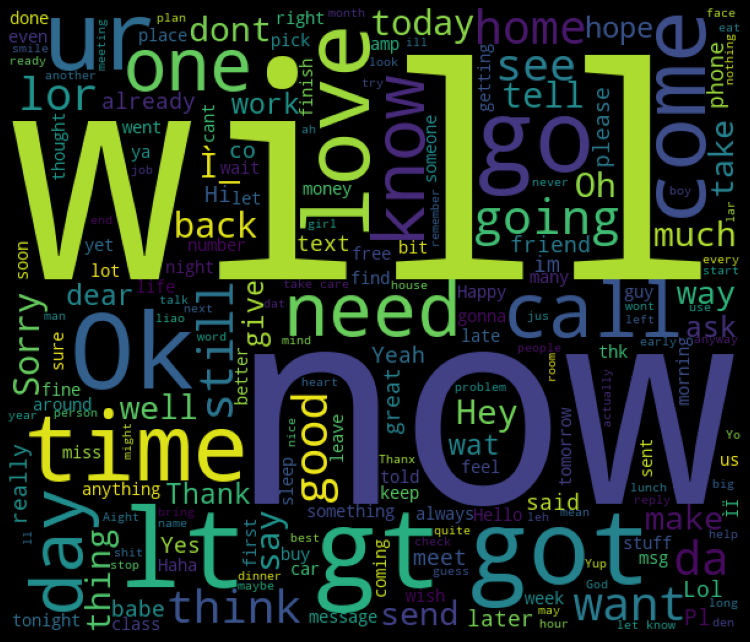

In [15]:
word_cloud('ham')

In [16]:
size_vocabulary = 1000   
embedding_dimension = 64  
trunc_type = 'post'
padding_type = 'post'
threshold = 0.5          
oov_token = "<OOV>"
test_size, valid_size = 0.05, 0.2
num_epochs = 20         
drop_level = 0.3         

In [17]:
print("\t\tStage I. Preliminary actions. Preparing of needed sets\n")
full_df_l = []
lemmatizer = WordNetLemmatizer()
for i in range(df_spam.shape[0]):
    mess_1 = df_spam.iloc[i, 1]
    mess_1 = re.sub('\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', mess_1)
    mess_1 = re.sub('(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr', mess_1) 
    mess_1 = re.sub('£|\$', 'moneysymb', mess_1) 
    mess_1 = re.sub('\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b', 'phonenumbr', mess_1) 
    mess_1 = re.sub('\d+(\.\d+)?', 'numbr', mess_1) 
    mess_1 = re.sub('[^\w\d\s]', ' ', mess_1) 
    mess_1 = re.sub('[^A-Za-z]', ' ', mess_1).lower() 
    token_messages = word_tokenize(mess_1)
    mess = []
    for word in token_messages:
        if word not in set(stopwords.words('english')):
            mess.append(lemmatizer.lemmatize(word))
    txt_mess = " ".join(mess)
    full_df_l.append(txt_mess)

		Stage I. Preliminary actions. Preparing of needed sets



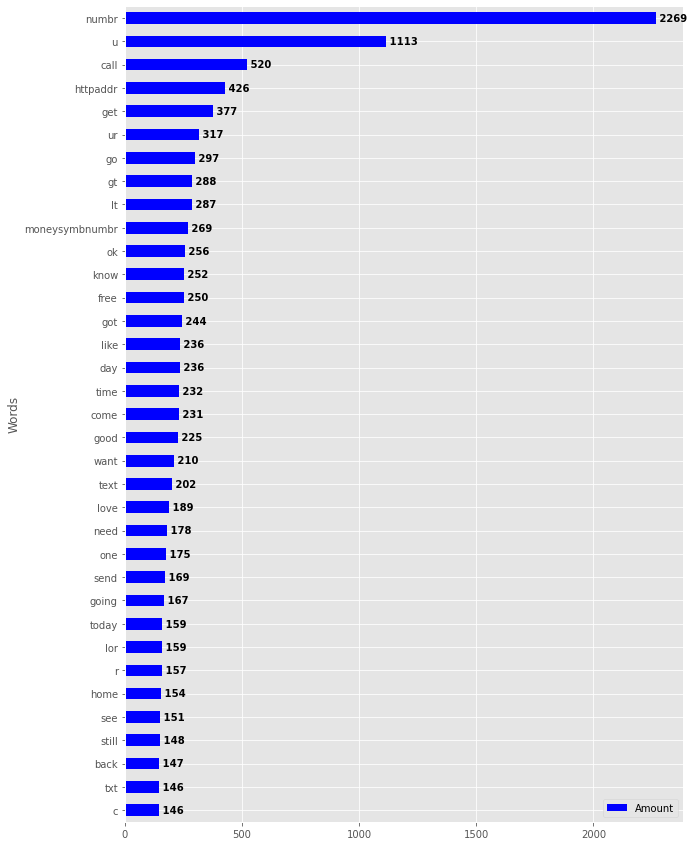

In [18]:
plot_words(full_df_l, number = 35)

In [19]:
add_df = CountVectorizer(max_features = size_vocabulary)
X = add_df.fit_transform(full_df_l).toarray()
y = df_spam.iloc[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = (test_size + valid_size), random_state = seed)
print('Number of rows in test set: ' + str(X_test.shape))
print('Number of rows in training set: ' + str(X_train.shape))

Number of rows in test set: (1293, 1000)
Number of rows in training set: (3876, 1000)


		Stage IIa. Guassian Naive Bayes

The first two predicted labels: spam ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.99      0.77      0.86      1107
        spam       0.40      0.94      0.56       186

    accuracy                           0.79      1293
   macro avg       0.69      0.85      0.71      1293
weighted avg       0.90      0.79      0.82      1293
 



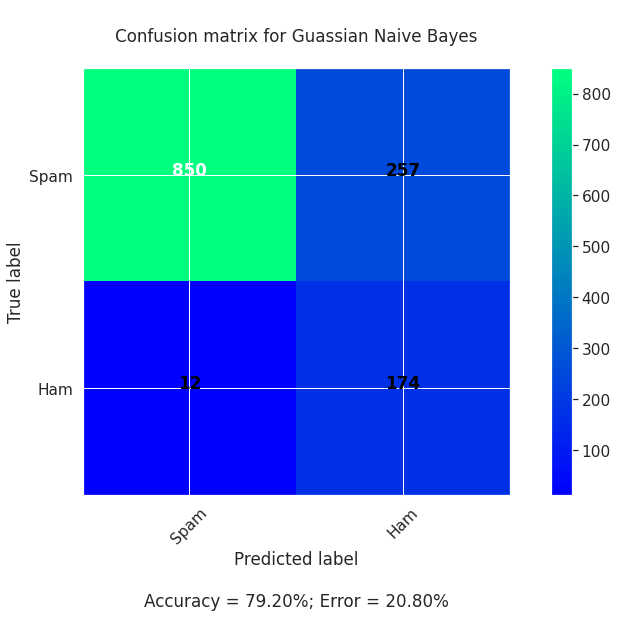

In [20]:
print("\t\tStage IIa. Guassian Naive Bayes\n")
class_NBC = GaussianNB().fit(X_train, y_train) 
y_pred_NBC = class_NBC.predict(X_test)
print('The first two predicted labels:', y_pred_NBC[0],y_pred_NBC[1], '\n')
conf_m_NBC = confusion_matrix(y_test, y_pred_NBC)
class_rep_NBC = classification_report(y_test, y_pred_NBC)
print('\t\t\tClassification report:\n\n', class_rep_NBC, '\n')
plot_conf_matr(conf_m_NBC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Guassian Naive Bayes')

		Stage IIb. Multinomial Naive Bayes

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.99      0.98      0.98      1107
        spam       0.90      0.92      0.91       186

    accuracy                           0.97      1293
   macro avg       0.94      0.95      0.95      1293
weighted avg       0.97      0.97      0.97      1293
 



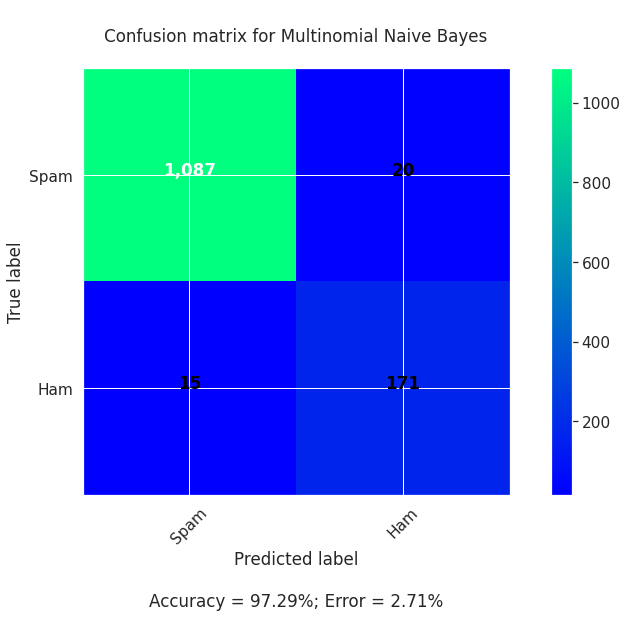

In [21]:
print("\t\tStage IIb. Multinomial Naive Bayes\n")
class_MNB = MultinomialNB().fit(X_train, y_train) 
y_pred_MNB = class_MNB.predict(X_test)
print('The first two predicted labels:', y_pred_MNB[0],y_pred_MNB[1], '\n')
conf_m_MNB = confusion_matrix(y_test, y_pred_MNB)
class_rep_MNB = classification_report(y_test, y_pred_MNB)
print('\t\t\tClassification report:\n\n', class_rep_MNB, '\n')
plot_conf_matr(conf_m_MNB, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Multinomial Naive Bayes')

		Stage III. Decision Tree Classifier

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.97      0.98      0.98      1107
        spam       0.87      0.84      0.86       186

    accuracy                           0.96      1293
   macro avg       0.92      0.91      0.92      1293
weighted avg       0.96      0.96      0.96      1293
 



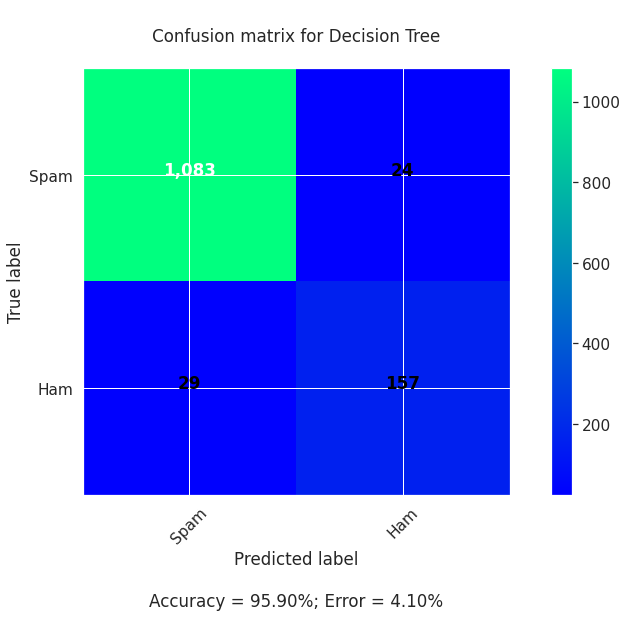

In [22]:
print("\t\tStage III. Decision Tree Classifier\n")
class_DTC = DecisionTreeClassifier(random_state = seed).fit(X_train, y_train)
y_pred_DTC = class_DTC.predict(X_test)
print('The first two predicted labels:', y_pred_DTC[0], y_pred_DTC[1], '\n')
conf_m_DTC = confusion_matrix(y_test, y_pred_DTC)
class_rep_DTC = classification_report(y_test, y_pred_DTC)
print('\t\t\tClassification report:\n\n', class_rep_DTC, '\n')
plot_conf_matr(conf_m_DTC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Decision Tree')

		Stage IV. Logistic Regression

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.97      0.86      0.91       186

    accuracy                           0.98      1293
   macro avg       0.97      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



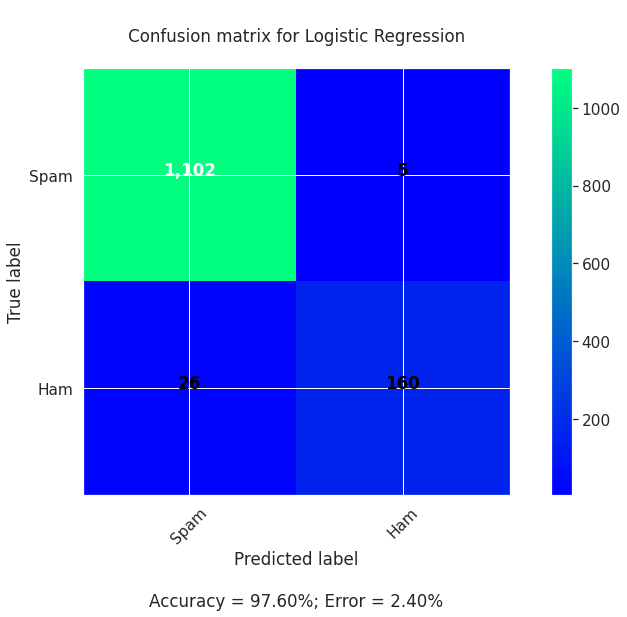

In [23]:
print("\t\tStage IV. Logistic Regression\n")
class_LR = LogisticRegression(random_state = seed, solver = 'liblinear').fit(X_train, y_train)
y_pred_LR = class_LR.predict(X_test)
print('The first two predicted labels:', y_pred_LR[0], y_pred_LR[1], '\n')
conf_m_LR = confusion_matrix(y_test, y_pred_LR)
class_rep_LR = classification_report(y_test, y_pred_LR)
print('\t\t\tClassification report:\n\n', class_rep_LR, '\n')
plot_conf_matr(conf_m_LR, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Logistic Regression')

		Stage V. KNeighbors Classifier

The firs two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.95      0.99      0.97      1107
        spam       0.93      0.70      0.80       186

    accuracy                           0.95      1293
   macro avg       0.94      0.85      0.89      1293
weighted avg       0.95      0.95      0.95      1293
 



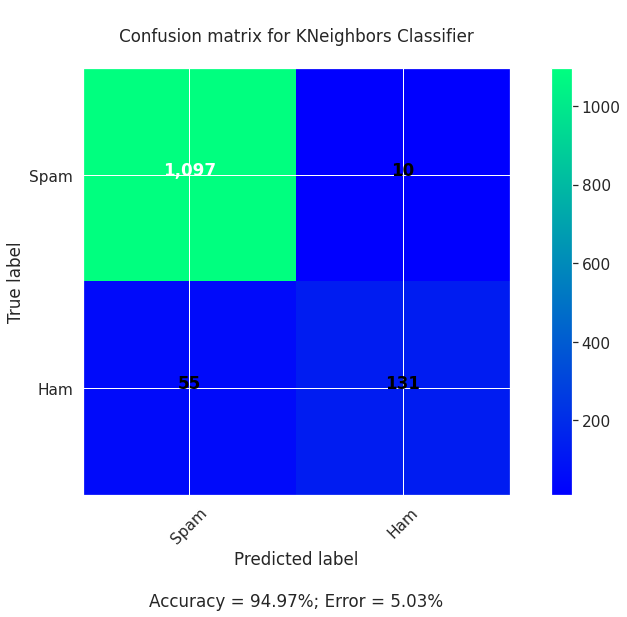

In [24]:
print("\t\tStage V. KNeighbors Classifier\n")
class_KNC = KNeighborsClassifier(n_neighbors = 3).fit(X_train, y_train)
y_pred_KNC = class_KNC.predict(X_test)
print('The firs two predicted labels:', y_pred_KNC[0], y_pred_KNC[1], '\n')
conf_m_KNC = confusion_matrix(y_test, y_pred_KNC)
class_rep_KNC = classification_report(y_test, y_pred_KNC)
print('\t\t\tClassification report:\n\n', class_rep_KNC, '\n')
plot_conf_matr(conf_m_KNC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for KNeighbors Classifier')

		Stage VI. Support Vector Classification

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      1.00      0.99      1107
        spam       0.98      0.86      0.91       186

    accuracy                           0.98      1293
   macro avg       0.98      0.93      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



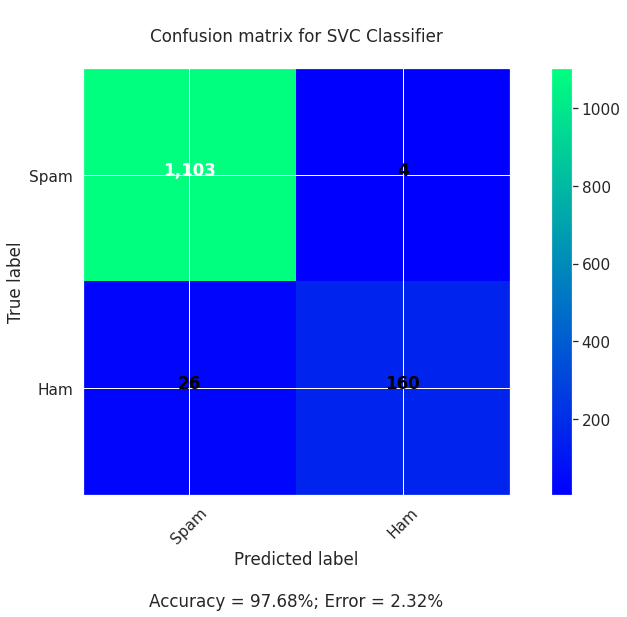

In [26]:
print("\t\tStage VI. Support Vector Classification\n")
class_SVC = SVC(probability = True, random_state = seed).fit(X_train, y_train)
y_pred_SVC = class_SVC.predict(X_test)
print('The first two predicted labels:', y_pred_SVC[0], y_pred_SVC[1], '\n')
conf_m_SVC = confusion_matrix(y_test, y_pred_SVC)
class_rep_SVC = classification_report(y_test, y_pred_SVC)
print('\t\t\tClassification report:\n\n', class_rep_SVC, '\n')
plot_conf_matr(conf_m_SVC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for SVC Classifier')

		Stage VII. Gradient Boosting Classifier

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.97      1.00      0.99      1107
        spam       0.99      0.84      0.91       186

    accuracy                           0.98      1293
   macro avg       0.98      0.92      0.95      1293
weighted avg       0.98      0.98      0.97      1293
 



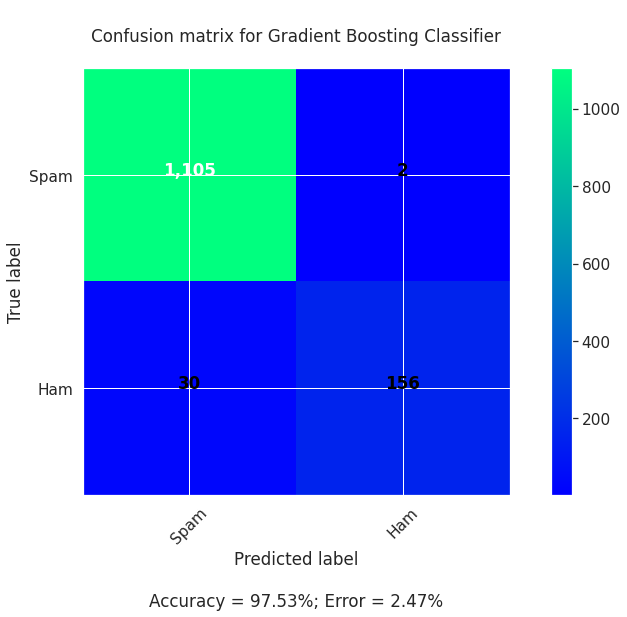

In [27]:
print("\t\tStage VII. Gradient Boosting Classifier\n")
class_GBC = GradientBoostingClassifier(random_state = seed).fit(X_train, y_train)
y_pred_GBC = class_GBC.predict(X_test)
print('The first two predicted labels:', y_pred_GBC[0], y_pred_GBC[1], '\n')
conf_m_GBC = confusion_matrix(y_test, y_pred_GBC)
class_rep_GBC = classification_report(y_test, y_pred_GBC)
print('\t\t\tClassification report:\n\n', class_rep_GBC, '\n')
plot_conf_matr(conf_m_GBC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Gradient Boosting Classifier')

		Stage VIII. Bagging Classifier + something else

The first two predicted labels: ham ham 

			Classification report:

               precision    recall  f1-score   support

         ham       0.98      0.99      0.99      1107
        spam       0.96      0.89      0.92       186

    accuracy                           0.98      1293
   macro avg       0.97      0.94      0.95      1293
weighted avg       0.98      0.98      0.98      1293
 



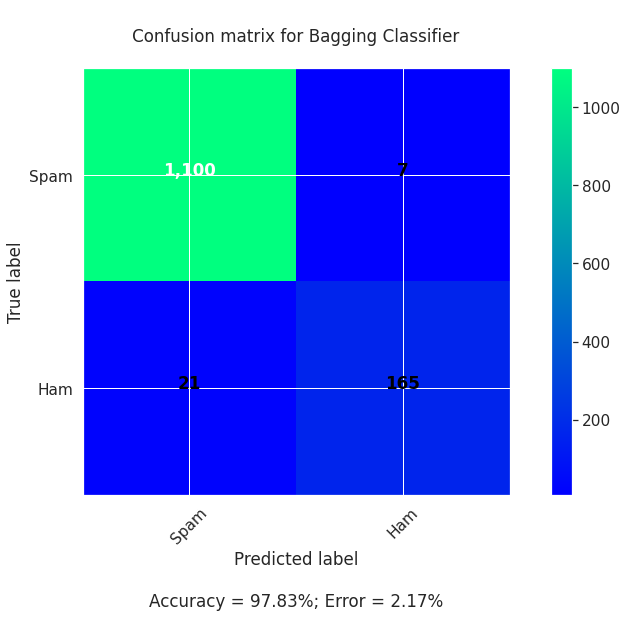

In [28]:
print("\t\tStage VIII. Bagging Classifier + something else\n")

class_BC = BaggingClassifier(class_SVC).fit(X_train, y_train)
y_pred_BC = class_BC.predict(X_test)
print('The first two predicted labels:', y_pred_BC[0], y_pred_BC[1], '\n')
conf_m_BC = confusion_matrix(y_test, y_pred_BC)
class_rep_BC = classification_report(y_test, y_pred_BC)
print('\t\t\tClassification report:\n\n', class_rep_BC, '\n')
plot_conf_matr(conf_m_BC, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for Bagging Classifier')

In [29]:
print("Stage I. Preliminary actions. Preparing of needed sets\n")

sentences_new_set = []
labels_new_set = []
for i in range(0, df_spam.shape[0], 1):
    sentences_new_set.append(df_spam['message'][i])
    labels_new_set.append(df_spam['feature'][i])

Stage I. Preliminary actions. Preparing of needed sets



In [30]:
train_size = int(df_spam.shape[0] * (1 - test_size - valid_size))
valid_bound = int(df_spam.shape[0] * (1 - valid_size))

train_sentences = sentences_new_set[0 : train_size]
valid_sentences = sentences_new_set[train_size : valid_bound]
test_sentences = sentences_new_set[valid_bound : ]

train_labels_str = labels_new_set[0 : train_size]
valid_labels_str = labels_new_set[train_size : valid_bound]
test_labels_str = labels_new_set[valid_bound : ]

In [32]:
print("Stage II. Labels transformations\n")

train_labels = [0] * len(train_labels_str)
for ind, item in enumerate(train_labels_str):
    if item == 'ham':
        train_labels[ind] = 1
    else:
        train_labels[ind] = 0
        
valid_labels = [0] * len(valid_labels_str)
for ind, item in enumerate(valid_labels_str):
    if item == 'ham':
        valid_labels[ind] = 1
    else:
        valid_labels[ind] = 0

test_labels = [0] * len(test_labels_str)
for ind, item in enumerate(test_labels_str):
    if item == 'ham':
        test_labels[ind] = 1
    else:
        test_labels[ind] = 0

train_labels = np.array(train_labels)
valid_labels = np.array(valid_labels)
test_labels = np.array(test_labels)

Stage II. Labels transformations



In [33]:
print("Stage III. Tokenization\n")

tokenizer = Tokenizer(num_words = size_vocabulary,
                      oov_token = oov_token,
                      lower = False)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

Stage III. Tokenization



In [34]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
size_voc = len(word_index) + 1
max_len = max([len(i) for i in train_sequences])
train_set = pad_sequences(train_sequences,
                                padding = padding_type,
                                maxlen = max_len,
                                truncating = trunc_type) 

valid_sequences = tokenizer.texts_to_sequences(valid_sentences)
valid_set = pad_sequences(valid_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_set = pad_sequences(test_sequences,
                               padding = padding_type,
                               maxlen = max_len,
                               truncating = trunc_type)

In [35]:
print("Stage IV. Model building\n")

model = Sequential([
    Embedding(size_voc, embedding_dimension, input_length = max_len),
    Bidirectional(LSTM(100)),
    Dropout(drop_level),
    Dense(20, activation = 'relu'),
    Dropout(drop_level),
    Dense(1, activation = 'sigmoid')
])

Stage IV. Model building



In [36]:
print("Stage V. Model compiling & fitting\n")
optim = Adam(learning_rate = 0.0001)

model.compile(loss = 'binary_crossentropy',
              optimizer = optim,
              metrics = ['accuracy'])
model.summary()

Stage V. Model compiling & fitting

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 189, 64)           606080    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               132000    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                4020      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 742,121
Trainable params: 742,121
Non-trainable params: 0
______________

In [38]:
history = model.fit(train_set, 
                    train_labels,
                    epochs = num_epochs, 
                    validation_data = (valid_set, valid_labels),
                    workers = os.cpu_count(),
                    use_multiprocessing = True,
                    verbose = 1)

Epoch 1/20
122/122 [==============================] - 12s 96ms/step - loss: 0.0223 - accuracy: 0.9959 - val_loss: 0.0737 - val_accuracy: 0.9884
Epoch 2/20
122/122 [==============================] - 12s 96ms/step - loss: 0.0205 - accuracy: 0.9956 - val_loss: 0.0735 - val_accuracy: 0.9884
Epoch 3/20
122/122 [==============================] - 12s 96ms/step - loss: 0.0172 - accuracy: 0.9964 - val_loss: 0.0778 - val_accuracy: 0.9884
Epoch 4/20
122/122 [==============================] - 12s 96ms/step - loss: 0.0146 - accuracy: 0.9969 - val_loss: 0.0773 - val_accuracy: 0.9846
Epoch 5/20
122/122 [==============================] - 12s 96ms/step - loss: 0.0140 - accuracy: 0.9961 - val_loss: 0.0851 - val_accuracy: 0.9807
Epoch 6/20
122/122 [==============================] - 12s 97ms/step - loss: 0.0163 - accuracy: 0.9972 - val_loss: 0.0817 - val_accuracy: 0.9846
Epoch 7/20
122/122 [==============================] - 12s 99ms/step - loss: 0.0127 - accuracy: 0.9972 - val_loss: 0.0856 - val_accuracy:

Stage VI. Results visualization



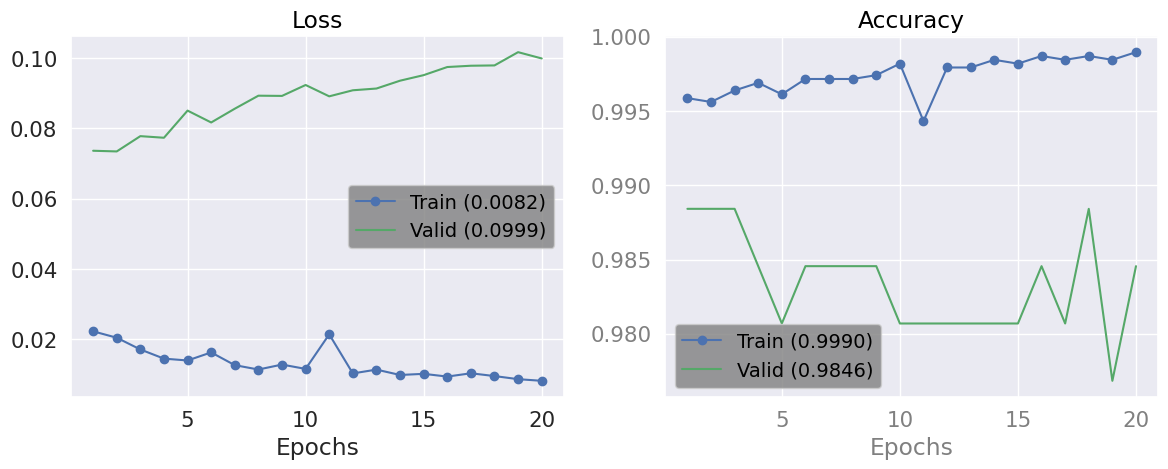

In [39]:
print("Stage VI. Results visualization\n")
plot_history(history)

In [40]:
model_score = model.evaluate(test_set, test_labels, batch_size = embedding_dimension, verbose = 1)
print(f"Test accuracy: {model_score[1] * 100:0.2f}% \t\t Test error: {model_score[0]:0.4f}")

17/17 [==============================] - 1s 33ms/step - loss: 0.0815 - accuracy: 0.9855
Test accuracy: 98.55% 		 Test error: 0.0815


In [41]:
M_name = "My_model"
pickle.dump(tokenizer, open(M_name + ".pkl", "wb"))
filepath = M_name + '.h5'
tf.keras.models.save_model(model, filepath, include_optimizer = True, save_format = 'h5', overwrite = True)
print("Size of the saved model :", os.stat(filepath).st_size, "bytes")

Size of the saved model : 8961600 bytes


			Classification report:

               precision    recall  f1-score   support

           0       0.95      0.92      0.94       117
           1       0.99      0.99      0.99       917

    accuracy                           0.99      1034
   macro avg       0.97      0.96      0.96      1034
weighted avg       0.99      0.99      0.99      1034
 



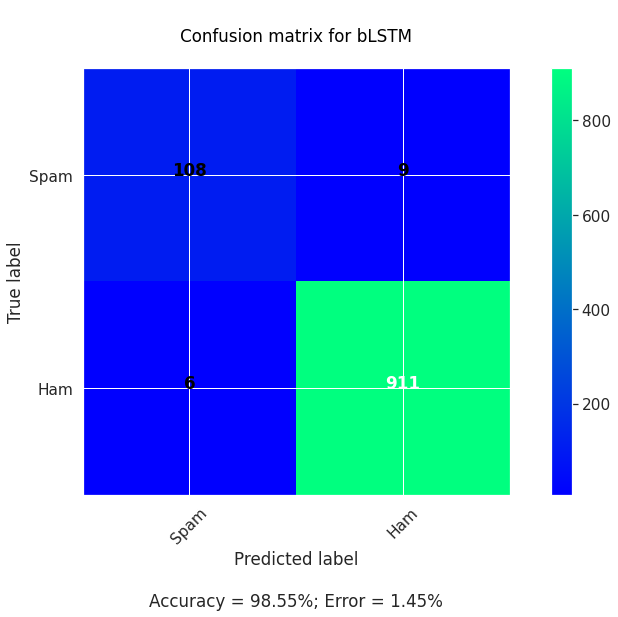

In [42]:
y_pred_bLSTM = model.predict(test_set)

y_prediction = [0] * y_pred_bLSTM.shape[0]
for ind, item in enumerate(y_pred_bLSTM):
    if item > threshold:
        y_prediction[ind] = 1
    else:
        y_prediction[ind] = 0

conf_m_bLSTM = confusion_matrix(test_labels, y_prediction)
class_rep_bLSTM = classification_report(test_labels, y_prediction)
print('\t\t\tClassification report:\n\n', class_rep_bLSTM, '\n')
plot_conf_matr(conf_m_bLSTM, classes = ['Spam','Ham'], normalize = False, title = 'Confusion matrix for bLSTM')

In [43]:

message_example = ["Darling, please give me a cup of tea"] 

message_example_tp = pad_sequences(tokenizer.texts_to_sequences(message_example),
                                   maxlen = max_len,
                                   padding = padding_type,
                                   truncating = trunc_type)

pred = float(model.predict(message_example_tp))
if (pred > threshold):
    print ("This message is a real text")
else:
    print("This message is a spam message")

This message is a real text
